##BERT Installations

In [1]:
#Install the server and client via pip. They can be installed separately or even on different machines
!pip install bert-serving-client

In [2]:
!pip install -U bert-serving-server[http]

     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 358kB 9.5MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=1e7aa2b27ff577cb1afa2a506af559f503bca5cab51cc4a6a11847ac3d1aead6
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
  Created wheel for flask-compress: filename=Flask_Compress-1.8.0-cp36-none-any.whl size=7215 sha256=158114214afe4bf6bccd67fdf38522ccf27ee524dc50c7e987119c91f7f5086c
  Stored in directory: /root/.cache/pip/wheels/f9/aa/e9/c4b763ea17eb0662124f67924cbfb9ee0efa83e28f6131baec
Successfully built GPUtil flask-compress


In [3]:
#Download a model listed below, then uncompress the zip file into some folder, say /tmp/english_L-12_H-768_A-12/
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-11-16 02:44:17--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   161MB/s    in 2.4s    

2020-11-16 02:44:19 (161 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [4]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [5]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [6]:
!nohup bert-serving-start -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 -max_seq_len=512 &

In [7]:
from bert_serving.client import BertClient
bc = BertClient()

#Dataset1-Big(85282 rows)

##Import Dataset

In [8]:
import pandas as pd;

#Loading dataset and rename columns

df=pd.read_excel("healthtapQAs_v1.xlsx");
df.columns=["questions","answers"];

df

,questions,answers
0,zirconium dental implants. how common is it us...,a majority of the dental implants placed are t...
1,zoloft/ sertaline cause heart racing can't sit...,check with your doc could be side effect of th...
2,zoloft (sertraline) side effects? does it make...,it can be related to either weight gain or los...
3,yellow skin around wound from cat bite. why?,this may be the secondary result of a resolvin...
4,yeast infection and open sores major swelling ...,bathing in a bath with baking soda may help de...
...,...,...
85277,what is the best: a conventional angiography o...,for small vessels conventional angiography is ...
85278,what is unique about taking medicine every 24 ...,try taking one half tab every day. but 10mg si...
85279,what treat should be of following sypmtoms pai...,your description of the pain sounds neuropathi...
85280,can you explain incomplete right bundle branch...,the righty and left ventricles are induced to ...


##Data Preprocessing

In [9]:
import re
import gensim 
from gensim.parsing.preprocessing import remove_stopwords

#keeping only words in the sentence and removing punctuations.

def clean_sentence(sentence, stopwords=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
    
    if stopwords:
         sentence = remove_stopwords(sentence)
    
    
    return sentence
                    
def get_cleaned_sentences(df,stopwords=False):    
    sents=df[["questions"]];
    cleaned_sentences=[]

    for index,row in df.iterrows():
        #print(index,row)
        cleaned=clean_sentence(row["questions"],stopwords);
        cleaned_sentences.append(cleaned);
    return cleaned_sentences;

cleaned_sentences=get_cleaned_sentences(df,stopwords=True)
#print(cleaned_sentences);


cleaned_sentences_with_stopwords=get_cleaned_sentences(df,stopwords=False)
#print(cleaned_sentences_with_stopwords[0]);

In [10]:
print(cleaned_sentences_with_stopwords[0]);

zirconium dental implants how common is it used now is there any advantages or benefits over titanium implants cons  pros please thanks


##BERT Embeddings

In [11]:
import sklearn

#finding cosine similarity from vectors
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
        sim=cosine_similarity(faq_embedding,question_embedding)[0][0];
        #print(index, sim, sentences[index])
        if sim>max_sim:
            max_sim=sim;
            index_sim=index;
    print("\n")
    print("Question: ",question)
    print("\n");
    print("Retrieved Question: ",FAQdf.iloc[index_sim,0]) 
    print("Retrieved Answer: ",FAQdf.iloc[index_sim,1]) 

In [12]:
#giving input question
question_orig="How to keep good health ?"
#cleaning the question
question=clean_sentence(question_orig,stopwords=False);

In [13]:
cleaned_sentences=get_cleaned_sentences(df,stopwords=False)
#creating word embeddings
import time
m1 = time.time()
sent_bertphrase_embeddings=[];

for sent in cleaned_sentences:
    sent_bertphrase_embeddings.append(bc.encode([sent]));
m2 = time.time()
print("Question Embedding time for Huge dataset",m2 - m1)
question_embedding=bc.encode([question]);

retrieveAndPrintFAQAnswer(question_embedding,sent_bertphrase_embeddings,df, cleaned_sentences);

Question Embedding time for Huge dataset 3334.6015825271606


Question:  how to keep good health 


Retrieved Question:  how to eat healthy and get fit?
Retrieved Answer:  portion control (use salad plate instead of dinner plate); 4-6 mini-meals/day; avoid fast food & sugary & diet drinks. lean meats plenty of fruits & veggies (choose low glycemic ones) low-fat dairy eggs good fats (olive/canola) avoid starches (bread/rice /potatoes/pasta—unless whole grain); exercise 30 min/day (walking/pool exercises); can add weights/ machines with guidance to prevent injury.


#Implementing Chatbot using BERT Model

In [14]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
import numpy
import time

print("Welcome to the Question Answering System")      

while True:
  print("Question:") 
  
  question_orig=input()
  
  if (question_orig.lower()=='quit'):
    break
  measure1 = time.time()
  question=clean_sentence(question_orig,stopwords=False);
  

  question_embedding=bc.encode([question]);  
  def retrieveAndPrintFAQAnswer(question_embedding,sentence_embeddings,FAQdf,sentences):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings):
      sim=cosine_similarity(faq_embedding,question_embedding)[0][0]
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;
    #print("\n")
    #print("Question: ",question)
    #print("\n");
    print("Retrieved: ",FAQdf.iloc[index_sim,0]) 
    #print(FAQdf.iloc[index_sim,1]) 
    print("Answer:",FAQdf.iloc[index_sim,1])
    print("----------------------")
    measure2 = time.time()
    print("Response Time",measure2 - measure1)
    print("----------------------")
    print("\n");
    print("Enter Quit to exit: ")
  retrieveAndPrintFAQAnswer(question_embedding,sent_bertphrase_embeddings,df, cleaned_sentences);




print("----------------------")
print("Thank You")
print("----------------------")

Welcome to the Question Answering System
Question:
How to take care of health?
Retrieved:  how to avoid obesity?
Answer: stay active and eat right. also make sure you get sleep and stay clear of excess stress.
----------------------
Response Time 14.445129871368408
----------------------


Enter Quit to exit: 
Question:
Give some tips for healthy lifestyle?
Retrieved:  give advise on weight loss programme?
Answer: weight loss is possible. it takes a regular change in habits. adopting a low glycemic diet is helpful for many. regular activity daily and vigorous activity two times per week. sleep and manage stress. some supplements and programs can be helpful. <link>
----------------------
Response Time 14.472314357757568
----------------------


Enter Quit to exit: 
Question:
Quit
----------------------
Thank You
----------------------


#Dataset2-Easy

##Import Dataset

In [15]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv");
df.columns=["questions","answers","Label"];

df

,questions,answers,Label
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [16]:
import pandas as pd;

#Load dataset and examine dataset, rename columns to questions and answers

df_test=pd.read_excel("FAQ_test_Easy.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,"How are the DS jobs on the market, please?",2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How is DS hiring impacted due to Covid?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,In a data scientist what qualifications and at...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Are employers looking for an advanced ML degree?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,On a typical day what does a data scientist do?,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,Do we need to study algorithms for a data scie...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,What is the mathematical background needed to ...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview are in a data sc...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How proficient a data scientist has to be in c...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##BERT Model

In [17]:
#cleaning test data questions
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test);

['how is the job searching experience nowadays', 'how are the ds jobs on the market please', 'how is ds hiring impacted due to covid', 'in a data scientist what qualifications and attributes do employers look for', 'are employers looking for an advanced ml degree', 'on a typical day what does a data scientist do', 'do we need to study algorithms for a data science interview', 'what is the mathematical background needed to be a data scientist ', 'how many rounds of interview are in a data science interview ', 'how proficient a data scientist has to be in coding']


In [18]:
#cleaning original data questions
cleaned_sentences=get_cleaned_sentences(df,stopwords=False)

In [19]:
print(cleaned_sentences)

['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 'what level of proficiency is needed for a data scientist in coding']


In [20]:
#Embedding original question dataset

sent_bertphrase_embeddings=[];

for sent in cleaned_sentences:
    sent_bertphrase_embeddings.append(bc.encode([sent]));

In [21]:
#Embeding test question dataset

sent_bertphrase_embeddings_test=[];
for sent_test in cleaned_sentences_test:
    sent_bertphrase_embeddings_test.append(bc.encode([sent_test]));


In [22]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embeddings_test1,sentence_embeddings1,FAQdf1,sentences1,FAQdf_test1,sentences_test1):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test1):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings1):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;

    FAQdf_test1.iloc[index_test,2]=FAQdf1.iloc[index_sim,2]
    FAQdf_test1.iloc[index_test,5]=FAQdf1.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test1[index_test])
    print("\n");
    print("Retrieved: ",FAQdf1.iloc[index_sim,0]) 
    print("Answer:",FAQdf1.iloc[index_sim,1])        
  df_test=FAQdf_test1 
retrieveAndPrintFAQAnswer(sent_bertphrase_embeddings_test,sent_bertphrase_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test);



Question:  how is the job searching experience nowadays


Retrieved:  What does the job hunting experience look like ?
Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can.


Question:  how are the ds jobs on the market please


Retrieved:  What does the job hunting experience look like ?
Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can.


Question:  how is ds hiring impacted due to covid


Retrieved:  What's

In [23]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,1.0,NaN,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,"How are the DS jobs on the market, please?",2,1.0,NaN,Any insights you can offer about the DS job ma...,What does the job hunting experience look like ?
2,How is DS hiring impacted due to Covid?,3,3.0,NaN,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,In a data scientist what qualifications and at...,4,4.0,NaN,What skills and qualities do employers look fo...,What skills and qualities do employers look fo...
4,Are employers looking for an advanced ML degree?,5,5.0,NaN,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,On a typical day what does a data scientist do?,6,6.0,NaN,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,Do we need to study algorithms for a data scie...,7,7.0,NaN,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,What is the mathematical background needed to ...,8,8.0,NaN,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview are in a data sc...,9,9.0,NaN,What are the various rounds in a data scientis...,What are the various rounds in a data scientis...
9,How proficient a data scientist has to be in c...,10,10.0,NaN,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [24]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How is the job searching experience nowadays?,1,1.0,correct,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,"How are the DS jobs on the market, please?",2,1.0,InCorrect,Any insights you can offer about the DS job ma...,What does the job hunting experience look like ?
2,How is DS hiring impacted due to Covid?,3,3.0,correct,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,In a data scientist what qualifications and at...,4,4.0,correct,What skills and qualities do employers look fo...,What skills and qualities do employers look fo...
4,Are employers looking for an advanced ML degree?,5,5.0,correct,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,On a typical day what does a data scientist do?,6,6.0,correct,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,Do we need to study algorithms for a data scie...,7,7.0,correct,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,What is the mathematical background needed to ...,8,8.0,correct,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview are in a data sc...,9,9.0,correct,What are the various rounds in a data scientis...,What are the various rounds in a data scientis...
9,How proficient a data scientist has to be in c...,10,10.0,correct,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [25]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [26]:
#printing confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[8, 1],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]]])

In [27]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

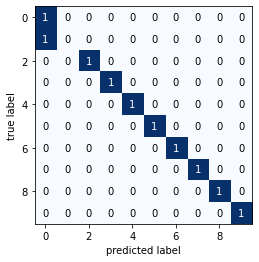

In [28]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#printing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [29]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.85      0.90      0.87        10
weighted avg       0.85      0.90      0.87        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Dataset3-Medium

##Import Dataset

In [30]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv");
df.columns=["questions","answers","Label"];

df

,questions,answers,Label
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [31]:
import pandas as pd;

#Load dataset and examine dataset, rename columns to questions and answers

df_test=pd.read_excel("FAQ_test_Medium.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,Please provide how DS jobs are in the market?,2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How has the Covid impacted DS hiring?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,What skills do employers want from data scienc...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Is advanced degree in ML required?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,What data scientist do in a typical day?,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,For an interview in data science are we requir...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,What is the mathematical background required t...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview are required to c...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How much proficient a data scientist should be...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##BERT Model

In [32]:
#cleaning test data questions
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test);

['how does job searching experience would look', 'please provide how ds jobs are in the market', 'how has the covid impacted ds hiring', 'what skills do employers want from data science positions', 'is advanced degree in ml required', 'what data scientist do in a typical day', 'for an interview in data science are we required to study algorithms', 'what is the mathematical background required to be a data scientist ', 'how many rounds of interview are required to clear data scientist interview ', 'how much proficient a data scientist should be in coding']


In [33]:
#cleaning original data questions
cleaned_sentences=get_cleaned_sentences(df,stopwords=False)

In [34]:
print(cleaned_sentences)

['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 'what level of proficiency is needed for a data scientist in coding']


In [35]:
#Embedding original question dataset

sent_bertphrase_embeddings=[];

for sent in cleaned_sentences:
    sent_bertphrase_embeddings.append(bc.encode([sent]));

In [36]:
#Embeding test question dataset

sent_bertphrase_embeddings_test=[];
for sent_test in cleaned_sentences_test:
    sent_bertphrase_embeddings_test.append(bc.encode([sent_test]));


In [37]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embeddings_test1,sentence_embeddings1,FAQdf1,sentences1,FAQdf_test1,sentences_test1):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test1):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings1):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;

    FAQdf_test1.iloc[index_test,2]=FAQdf1.iloc[index_sim,2]
    FAQdf_test1.iloc[index_test,5]=FAQdf1.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test1[index_test])
    print("\n");
    print("Retrieved: ",FAQdf1.iloc[index_sim,0]) 
    print("Answer:",FAQdf1.iloc[index_sim,1])        
  df_test=FAQdf_test1 
retrieveAndPrintFAQAnswer(sent_bertphrase_embeddings_test,sent_bertphrase_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test);



Question:  how does job searching experience would look


Retrieved:  What does the job hunting experience look like ?
Answer: Job hunting experience involves networking to get in touch with the right people in various companies, applying to lots of jobs through various channels, preparing for interviews – while interviews are uncertain it is necessary to prepare well what you CAN prepare, smart scheduling of interviews to get the best job and salary you can.


Question:  please provide how ds jobs are in the market


Retrieved:  Any insights you can offer about the DS job market ?
Answer: There are many kinds of roles, data scientist, analyst, data engineer and so on. There are many levels of companies. In smaller companies the roles are usually combined into one while in larger companies there are more nuanced roles. Since more and more companies are just getting started on their data journey, the overall demand is expected to increase in the next few years.


Question:  how has th

In [38]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,1.0,NaN,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,Please provide how DS jobs are in the market?,2,2.0,NaN,Any insights you can offer about the DS job ma...,Any insights you can offer about the DS job ma...
2,How has the Covid impacted DS hiring?,3,3.0,NaN,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,What skills do employers want from data scienc...,4,4.0,NaN,What skills and qualities do employers look fo...,What skills and qualities do employers look fo...
4,Is advanced degree in ML required?,5,5.0,NaN,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What data scientist do in a typical day?,6,6.0,NaN,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,For an interview in data science are we requir...,7,7.0,NaN,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,What is the mathematical background required t...,8,8.0,NaN,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview are required to c...,9,7.0,NaN,What are the various rounds in a data scientis...,Is preparation of algorithms and data structur...
9,How much proficient a data scientist should be...,10,10.0,NaN,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [39]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How does job searching experience would look?,1,1.0,correct,What does the job hunting experience look like ?,What does the job hunting experience look like ?
1,Please provide how DS jobs are in the market?,2,2.0,correct,Any insights you can offer about the DS job ma...,Any insights you can offer about the DS job ma...
2,How has the Covid impacted DS hiring?,3,3.0,correct,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,What skills do employers want from data scienc...,4,4.0,correct,What skills and qualities do employers look fo...,What skills and qualities do employers look fo...
4,Is advanced degree in ML required?,5,5.0,correct,Do employers look for an advanced ML degree?,Do employers look for an advanced ML degree?
5,What data scientist do in a typical day?,6,6.0,correct,How does a typical day of a data scientist loo...,How does a typical day of a data scientist loo...
6,For an interview in data science are we requir...,7,7.0,correct,Is preparation of algorithms and data structur...,Is preparation of algorithms and data structur...
7,What is the mathematical background required t...,8,8.0,correct,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview are required to c...,9,7.0,InCorrect,What are the various rounds in a data scientis...,Is preparation of algorithms and data structur...
9,How much proficient a data scientist should be...,10,10.0,correct,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [40]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [41]:
#printing confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[8, 1],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [0, 1]]])

In [42]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

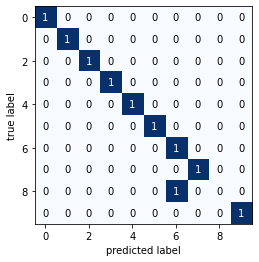

In [43]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#printing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [44]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1
          10       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.85      0.90      0.87        10
weighted avg       0.85      0.90      0.87        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Dataset3-Hard

##Import Dataset

In [45]:
import pandas as pd;

#Loading dataset and renaming columns

df=pd.read_csv("FAQ_standard.csv");
df.columns=["questions","answers","Label"];

df

,questions,answers,Label
0,What does the job hunting experience look like ?,Job hunting experience involves networking to ...,1
1,Any insights you can offer about the DS job ma...,"There are many kinds of roles, data scientist,...",2
2,What's the impact of Covid on hiring for DS ro...,Hiring is going to slow down. First in small c...,3
3,What skills and qualities do employers look fo...,The following are some skills employers usuall...,4
4,Do employers look for an advanced ML degree?,For more senior roles: People typically look f...,5
5,How does a typical day of a data scientist loo...,Here are some tasks in the typical day of a da...,6
6,Is preparation of algorithms and data structur...,Yes. In many data science interviews (ML Scien...,7
7,What is the mathematical background required t...,The following three are the basic building blo...,8
8,What are the various rounds in a data scientis...,Usually the data science interview has a subse...,9
9,What level of proficiency is needed for a data...,"Needs to be reasonably proficient. Again, a da...",10


In [46]:
import pandas as pd;

#Load dataset and examine dataset, rename columns to questions and answers

df_test=pd.read_excel("FAQ_test_Hard.xlsx")
df_test.columns=["questions","ActualCode","PredictedCode","Prediction?","ActualQuestion","PredictedQuestion"]

df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,NaN,NaN,What does the job hunting experience look like ?,NaN
1,Please provide how data science jobs are in th...,2,NaN,NaN,Any insights you can offer about the DS job ma...,NaN
2,How has the Covid impacted job?,3,NaN,NaN,What's the impact of Covid on hiring for DS ro...,NaN
3,Tell me about the skills required for Data sci...,4,NaN,NaN,What skills and qualities do employers look fo...,NaN
4,Is advanced knowledge of ML required?,5,NaN,NaN,Do employers look for an advanced ML degree?,NaN
5,What are the tasks performed by a data scienti...,6,NaN,NaN,How does a typical day of a data scientist loo...,NaN
6,How much is data structure important for data ...,7,NaN,NaN,Is preparation of algorithms and data structur...,NaN
7,How much maths knowledge is required to get a ...,8,NaN,NaN,What is the mathematical background required t...,NaN
8,How many rounds of interview is done for data ...,9,NaN,NaN,What are the various rounds in a data scientis...,NaN
9,How much coding experience is required for dat...,10,NaN,NaN,What level of proficiency is needed for a data...,NaN


##BERT Model

In [47]:
#cleaning test data questions
cleaned_sentences_test=get_cleaned_sentences(df_test,stopwords=False)
print(cleaned_sentences_test);

['how difficult is it to find a job', 'please provide how data science jobs are in the market', 'how has the covid impacted job', 'tell me about the skills required for data science in the industry', 'is advanced knowledge of ml required', 'what are the tasks performed by a data scientist in a day', 'how much is data structure important for data science positions', 'how much maths knowledge is required to get a data science job', 'how many rounds of interview is done for data science roles', 'how much coding experience is required for data science positions']


In [48]:
#cleaning original data questions
cleaned_sentences=get_cleaned_sentences(df,stopwords=False)

In [49]:
print(cleaned_sentences)

['what does the job hunting experience look like ', 'any insights you can offer about the ds job market ', 'whats the impact of covid on hiring for ds roles', 'what skills and qualities do employers look for in a data scientist', 'do employers look for an advanced ml degree', 'how does a typical day of a data scientist look like', 'is preparation of algorithms and data structures needed for a data science interview ', 'what is the mathematical background required to be a data scientist ', 'what are the various rounds in a data scientist interview ', 'what level of proficiency is needed for a data scientist in coding']


In [50]:
#Embedding original question dataset

sent_bertphrase_embeddings=[];

for sent in cleaned_sentences:
    sent_bertphrase_embeddings.append(bc.encode([sent]));

In [51]:
#Embeding test question dataset

sent_bertphrase_embeddings_test=[];
for sent_test in cleaned_sentences_test:
    sent_bertphrase_embeddings_test.append(bc.encode([sent_test]));


In [52]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity;
def retrieveAndPrintFAQAnswer(question_embeddings_test1,sentence_embeddings1,FAQdf1,sentences1,FAQdf_test1,sentences_test1):
  for index_test,faq_embedding_test in enumerate(question_embeddings_test1):
    max_sim=-1;
    index_sim=-1;
    for index,faq_embedding in enumerate(sentence_embeddings1):
        
      sim=cosine_similarity(faq_embedding,faq_embedding_test)[0][0];
      #print(index, sim, sentences[index])
      if sim>max_sim:
        max_sim=sim;
        index_sim=index;

    FAQdf_test1.iloc[index_test,2]=FAQdf1.iloc[index_sim,2]
    FAQdf_test1.iloc[index_test,5]=FAQdf1.iloc[index_sim,0]
    print("\n")
    print("Question: ",sentences_test1[index_test])
    print("\n");
    print("Retrieved: ",FAQdf1.iloc[index_sim,0]) 
    print("Answer:",FAQdf1.iloc[index_sim,1])        
  df_test=FAQdf_test1 
retrieveAndPrintFAQAnswer(sent_bertphrase_embeddings_test,sent_bertphrase_embeddings,df,cleaned_sentences,df_test,cleaned_sentences_test);



Question:  how difficult is it to find a job


Retrieved:  What is the mathematical background required to be a data scientist ?
Answer: The following three are the basic building blocks in terms of data science math background: Linear Algebra, Probability and Statistics and Calculus and optimization.


Question:  please provide how data science jobs are in the market


Retrieved:  Any insights you can offer about the DS job market ?
Answer: There are many kinds of roles, data scientist, analyst, data engineer and so on. There are many levels of companies. In smaller companies the roles are usually combined into one while in larger companies there are more nuanced roles. Since more and more companies are just getting started on their data journey, the overall demand is expected to increase in the next few years.


Question:  how has the covid impacted job


Retrieved:  What's the impact of Covid on hiring for DS roles?
Answer: Hiring is going to slow down. First in small companies th

In [53]:
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,8.0,NaN,What does the job hunting experience look like ?,What is the mathematical background required t...
1,Please provide how data science jobs are in th...,2,2.0,NaN,Any insights you can offer about the DS job ma...,Any insights you can offer about the DS job ma...
2,How has the Covid impacted job?,3,3.0,NaN,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,Tell me about the skills required for Data sci...,4,10.0,NaN,What skills and qualities do employers look fo...,What level of proficiency is needed for a data...
4,Is advanced knowledge of ML required?,5,7.0,NaN,Do employers look for an advanced ML degree?,Is preparation of algorithms and data structur...
5,What are the tasks performed by a data scienti...,6,9.0,NaN,How does a typical day of a data scientist loo...,What are the various rounds in a data scientis...
6,How much is data structure important for data ...,7,8.0,NaN,Is preparation of algorithms and data structur...,What is the mathematical background required t...
7,How much maths knowledge is required to get a ...,8,8.0,NaN,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview is done for data ...,9,7.0,NaN,What are the various rounds in a data scientis...,Is preparation of algorithms and data structur...
9,How much coding experience is required for dat...,10,10.0,NaN,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [54]:
for i in range(df_test.shape[0]):
 if df_test.iloc[i,1]!=df_test.iloc[i,2]:
   df_test.iloc[i,3]='InCorrect'
 else:
   df_test.iloc[i,3]='correct'
df_test

,questions,ActualCode,PredictedCode,Prediction?,ActualQuestion,PredictedQuestion
0,How difficult is it to find a job?,1,8.0,InCorrect,What does the job hunting experience look like ?,What is the mathematical background required t...
1,Please provide how data science jobs are in th...,2,2.0,correct,Any insights you can offer about the DS job ma...,Any insights you can offer about the DS job ma...
2,How has the Covid impacted job?,3,3.0,correct,What's the impact of Covid on hiring for DS ro...,What's the impact of Covid on hiring for DS ro...
3,Tell me about the skills required for Data sci...,4,10.0,InCorrect,What skills and qualities do employers look fo...,What level of proficiency is needed for a data...
4,Is advanced knowledge of ML required?,5,7.0,InCorrect,Do employers look for an advanced ML degree?,Is preparation of algorithms and data structur...
5,What are the tasks performed by a data scienti...,6,9.0,InCorrect,How does a typical day of a data scientist loo...,What are the various rounds in a data scientis...
6,How much is data structure important for data ...,7,8.0,InCorrect,Is preparation of algorithms and data structur...,What is the mathematical background required t...
7,How much maths knowledge is required to get a ...,8,8.0,correct,What is the mathematical background required t...,What is the mathematical background required t...
8,How many rounds of interview is done for data ...,9,7.0,InCorrect,What are the various rounds in a data scientis...,Is preparation of algorithms and data structur...
9,How much coding experience is required for dat...,10,10.0,correct,What level of proficiency is needed for a data...,What level of proficiency is needed for a data...


In [55]:
list_data_answers=df_test.ActualCode.values.tolist()
list_data_FoundCode=df_test.PredictedCode.values.tolist()

In [56]:
#printing confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
multilabel_confusion_matrix(list_data_answers, list_data_FoundCode)
#tn, fp, fn, tp = confusion_matrix([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1.0, 2.0, 2.0, 10.0, 4.0, 1.0, 2.0, 1.0, 2.0, 2.0]).ravel()
#print(metrics.classification_report(list_data_answers, list_data_FoundCode))

array([[[9, 0],
        [1, 0]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [0, 1]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[9, 0],
        [1, 0]],

       [[7, 2],
        [1, 0]],

       [[7, 2],
        [0, 1]],

       [[8, 1],
        [1, 0]],

       [[8, 1],
        [0, 1]]])

In [57]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(list_data_answers, list_data_FoundCode, binary=False)

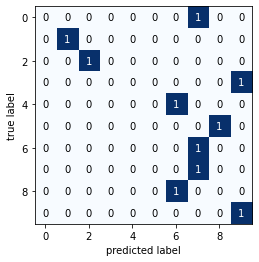

In [58]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pprint
#printing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [59]:
print(metrics.classification_report(list_data_answers, list_data_FoundCode))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.33      1.00      0.50         1
           9       0.00      0.00      0.00         1
          10       0.50      1.00      0.67         1

    accuracy                           0.40        10
   macro avg       0.28      0.40      0.32        10
weighted avg       0.28      0.40      0.32        10



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
